# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [48]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [4]:
rate_tree = pd.DataFrame({'0':[.0174,np.nan],'0.5':[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree.style.format('{:.2%}',na_rep='')

time $t$,0,0.5
node,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [5]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

### 1.4 
What is the price of the swap?

## 1.1

In [1]:
MATUND = 1 #T=1
FACE = 100

In [11]:
rate_tree.columns = [float(name) for name in rate_tree.columns]
rate_tree

,0.0,0.5
node,,
0,0.0174,0.0339
1,NaN,0.0095


In [12]:
bond_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)

for i in bond_tree.columns[-1:0:-1]:
    bond_tree[i] = np.exp(-rate_tree[i]*(MATUND-i)) * FACE

bond_tree.iloc[0,0] = term_struct.loc[MATUND,'price']
bond_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

,0.0,0.5
node,,
0,97.8925,98.3193
1,nan,99.5261


## 1.2

In [13]:
dt = .5

A = np.exp(rate_tree.iloc[0,0] * dt) ## GROWTH FACTOR
Z = np.exp(-rate_tree.iloc[0,0] * dt) ## DISCOUNT FACTOR

pstar = (A * bond_tree.loc[0, 0] - bond_tree.loc[1,dt])/(bond_tree.loc[0,dt] - bond_tree.loc[1,dt]) ## RISK-NEUTRAL PROBABILITY

pvec = pd.DataFrame([pstar,1-pstar],index=['prob up','prob down'],columns=[''])
pvec.style.format('{:.2%}')

,
prob up,64.49%
prob down,35.51%


## 1.3

In [15]:
STRIKE = .02
payoff = lambda r: FACE/2 * (r-STRIKE)
swap_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
swap_tree[dt] = payoff(rate_tree[dt])
swap_tree

,0.0,0.5
node,,
0,NaN,0.695
1,NaN,-0.525


In [14]:
def replicating_port(quotes, undertree, derivtree, dt=None, Ncash=100):
    """
    Function to calculate the replicating portfolio for a derivative security using binomial trees.

    Parameters:
    - quotes: List or array of quotes for the derivative security at each node in the tree.
    - undertree: DataFrame representing the binomial tree for the underlying asset.
    - derivtree: DataFrame representing the binomial tree for the derivative security.
    - dt: Time step size. If None, it is inferred from the columns of undertree.
    - Ncash: Number of cash units used in the replicating portfolio.

    Returns:
    - DataFrame with positions and values of each component in the replicating portfolio.
    """
    # If dt is not provided, infer it from the columns of undertree
    if dt is None:
        dt = undertree.columns[1] - undertree.columns[0]
    
    # Calculate delta, the hedge ratio
    delta = (derivtree.loc[0, dt] - derivtree.loc[1, dt]) / (undertree.loc[0, dt] - undertree.loc[1, dt]) 
    
    # Calculate the amount of cash required in the portfolio
    cash = (derivtree.loc[0, dt] - delta * undertree.loc[0, dt]) / Ncash
    
    # Create DataFrame to store positions and values
    out = pd.DataFrame({'positions': [cash, delta], 'value': quotes}, index=['cash', 'under'])
    
    # Calculate value of the derivative position
    out.loc['derivative', 'value'] = out['positions'] @ out['value']
    
    return out

In [16]:
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, swap_tree).style.format('{:.4f}')

,positions,value
cash,1.0009,99.1338
under,-1.0109,97.8925
derivative,nan,0.2595


## 1.4

In [17]:
# time 0 price of swap is discount factor * expected value of swap at time 1. Z * (p* swap up + (1-p*) swap down)
swap_tree.loc[0, 0] = Z * np.array([pstar, 1-pstar]) @ swap_tree[dt].values

swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1)

,0.0,0.5
node,,
0,0.2595,0.6950
1,nan,-0.5250


# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

In [18]:
def payoff_bond(r, dt, facevalue=100):
    """
    Calculates the payoff of a bond given the interest rate and time increment.

    Parameters:
    - r: Interest rate.
    - dt: Time increment.
    - facevalue: Face value of the bond.

    Returns:
    - The price of the bond.
    """
    price = np.exp(-r * dt) * facevalue
    return price
    
def bintree_pricing(payoff=None, ratetree=None, undertree=None, cftree=None, dt=None, pstars=None, timing=None, cfdelay=False, style='european', Tamerican=0):
    """
    Calculates the price tree of a derivative security using a binomial tree approach.

    Parameters:
    - payoff: A function representing the payoff of the derivative security.
    - ratetree: DataFrame representing the binomial tree for interest rates.
    - undertree: DataFrame representing the binomial tree for the underlying asset.
    - cftree: DataFrame representing the binomial tree for cash flows.
    - dt: Time step size.
    - pstars: Series representing probabilities at each node.
    - timing: Timing of cash flows ('deferred' for deferred cash flows).
    - cfdelay: Boolean indicating whether to delay cash flows.
    - style: Pricing style ('european' or 'american').
    - Tamerican: Time of exercising for American style options.

    Returns:
    - DataFrame representing the price tree of the derivative security.
    """
    # Default values for parameters if not provided
    if payoff is None:
        payoff = lambda r: 0
    if undertree is None:
        undertree = ratetree
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)
    if dt is None:
        dt = undertree.columns[1] - undertree.columns[0]
    
    # Handle deferred timing
    if timing == 'deferred':
        cfdelay = True
    
    # Display warning if dt is small and cfdelay is enabled
    if dt < .25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')
        
    # Initialize value tree DataFrame
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    # Loop through time steps to calculate the price tree
    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back == 0:                           
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t] * dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state, -steps_back] + (1 - pstars[t]) * valuetree.iloc[state + 1, -steps_back]
                
                if cfdelay:
                    cf = cftree.loc[state, t]
                else:                    
                    cf = cftree.iloc[state, -steps_back]
                
                valuetree.loc[state, t] = np.exp(-ratetree.loc[state, t] * dt) * (val_avg + cf)

            if style == 'american':
                if t >= Tamerican:
                    valuetree.loc[:, t] = np.maximum(valuetree.loc[:, t], payoff(undertree.loc[:, t]))
        
    return valuetree


def bond_price_error(quote, pstars, ratetree, style='european'):
    """
    Calculates the error between the model price and the quoted price of a bond.

    Parameters:
    - quote: Quoted price of the bond.
    - pstars: Series representing probabilities at each node.
    - ratetree: DataFrame representing the binomial tree for interest rates.
    - style: Pricing style ('european' or 'american').

    Returns:
    - Error between the model price and the quoted price.
    """
    FACEVALUE = 100
    dt = ratetree.columns[1] - ratetree.columns[0]    
    payoff = lambda r: payoff_bond(r, dt)
    modelprice = bintree_pricing(payoff, ratetree, pstars=pstars, style=style).loc[0, 0]
    error = modelprice - quote

    return error 

def estimate_pstar(quotes, ratetree, style='european'):
    """
    Estimates the probabilities at each node in the binomial tree for interest rates.

    Parameters:
    - quotes: DataFrame containing bond quotes.
    - ratetree: DataFrame representing the binomial tree for interest rates.
    - style: Pricing style ('european' or 'american').

    Returns:
    - Series representing probabilities at each node.
    """
    pstars = pd.Series(dtype=float, index=ratetree.columns[:-1], name='pstar')
    p0 = .5
    
    for steps_forward, t in enumerate(ratetree.columns[1:]):        
        ratetreeT = ratetree.copy().loc[:, :t].dropna(axis=0, how='all')
        t_prev = ratetreeT.columns[steps_forward]
        
        pstars_solved = pstars.loc[:t_prev].iloc[:-1]
        wrapper_fun = lambda p: bond_price_error(quotes['price'].iloc[steps_forward + 1], pd.concat([pstars_solved, pd.Series(p, index=[t_prev])]), ratetreeT, style=style)

        pstars[t_prev] = fsolve(wrapper_fun, p0)[0]

    return pstars

def format_bintree(df, style='{:.2f}'):
    """
    Formats a DataFrame representing a binomial tree.

    Parameters:
    - df: DataFrame representing the binomial tree.
    - style: Format style for the values.

    Returns:
    - Formatted DataFrame.
    """
    return df.style.format(style, na_rep='').format_index('{:.2f}', axis=1)

## 2.1

In [21]:
swap_tree.style.format('{:.4f}').format_index('{:.1f}', axis=1)

,0.0,0.5
node,,
0,0.2595,0.6950
1,nan,-0.5250


## 2.2

In [24]:
from scipy.optimize import fsolve

# we have market quotes on the zero-coupon bonds, so we use those prices here
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1],['price']],rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

,0.00
pstar,64.49%


## 2.3

In [26]:
EXPIRATION = .5
STRIKE = .02
payoff = lambda r: FACE * np.maximum(STRIKE - r,0)

In [27]:
# FIRST METHOD
# Pricing with P*
floorlet_tree = pd.DataFrame(dtype=float, columns=rate_tree.columns, index=rate_tree.index)
floorlet_tree[EXPIRATION] = payoff(rate_tree[EXPIRATION])
floorlet_tree.loc[0,0] = Z * np.array([pstar, 1-pstar])@floorlet_tree[EXPIRATION]
format_bintree(floorlet_tree,style='{:.4f}')

,0.00,0.50
node,,
0,0.3697,0.0000
1,,1.0500


In [28]:
# Second Method
# Pricing with replicating portfolio
replicating_port([term_struct.loc[.5,'price'],swap_tree.loc[0,0]], swap_tree, floorlet_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,0.0060,99.1338
under,-0.8607,0.2595
derivative,nan,0.3697


# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

## 3.1

In [29]:
STRIKE = 99
payoff = lambda p: np.maximum(p-STRIKE, 0)

derivtree = bintree_pricing(payoff, rate_tree, undertree=bond_tree, pstars=pstars)
format_bintree(derivtree,style='{:.4f}')

,0.00,0.50
node,,
0,0.1852,0.0000
1,,0.5261


## 3.2

In [30]:
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, derivtree, dt=.5).style.format('{:.4f}')

,positions,value
cash,-0.4286,99.1338
under,0.4360,97.8925
derivative,nan,0.1852


# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [32]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series(['0','0.5','1'],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='')

time $t$,0,0.5,1
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)
* strike is 99

### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $T_{\text{opt}}=1$
* written on bond maturing at $T_{\text{bond}}=1.5$

## 4.1

In [33]:
# Change the type of the column names
rate_tree_multi.columns = [float(name) for name in rate_tree_multi.columns]
rate_tree_multi

,0.0,0.5,1.0
node,,,
0,0.0174,0.0339,0.0500
1,NaN,0.0095,0.0256
2,NaN,NaN,0.0011


In [34]:
pstars = estimate_pstar(term_struct,rate_tree_multi)

payoff = lambda r: payoff_bond(r,dt)

bondtree_multi = bintree_pricing(payoff, ratetree=rate_tree_multi, pstars=pstars)
format_bintree(bondtree_multi, style='{:.4f}')

,0.00,0.50,1.00
node,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450


## 4.2

In [35]:
pstars

0.0    0.644862
0.5    0.786913
Name: pstar, dtype: float64

## 4.3

In [38]:
STRIKE = 99
call_payoff = lambda p: np.maximum(p-STRIKE, 0)

call_derivtree = bintree_pricing(call_payoff, rate_tree_multi, undertree=bondtree_multi, pstars=pstars)
format_bintree(call_derivtree,style='{:.4f}')

,0.00,0.50,1.00
node,,,
0,0.0706,0.0000,0.0000
1,,0.2004,0.0000
2,,,0.9450


## 4.4

In [40]:
def construct_rate_tree(dt,T):
    """
    Constructs a rate tree based on the given time step and time horizon.

    Parameters:
    dt (float): The time step.
    T (float): The time horizon.

    Returns:
    pd.DataFrame: The rate tree.
    """
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree

In [41]:
dt = 1/30
TMAT = 1.5
#Assuming annualized 3% volatility from last years notes
sigma = .3
up = np.exp(sigma*np.sqrt(dt))
down = np.exp(-sigma*np.sqrt(dt))

ratetree_dense = construct_rate_tree(dt, TMAT-dt)
ratetree_dense.loc[0,0] = rate_tree.loc[0,0]

for tsteps in range(ratetree_dense.shape[1]-1):
    ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] * up        
    ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] * down


format_bintree(ratetree_dense,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%,18.34%,19.37%
1,,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%
2,,,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%
3,,,,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%
4,,,,,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%
5,,,,,,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%
6,,,,,,,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%
7,,,,,,,,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%
8,,,,,,,,,1.12%,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%


In [43]:
pstars = pd.Series(.6449, index=ratetree_dense.columns, name='pstar') # need market data. using from throughout problem
format_bintree(pstars.to_frame().T,style='{:.2%}')
payoff = lambda r: payoff_bond(r,dt)
bondtree_dense = bintree_pricing(payoff, ratetree_dense, pstars = pstars)
STRIKE = 99
call_derivtree_dense = bintree_pricing(call_payoff, ratetree=ratetree_dense, undertree = bondtree_dense, pstars=pstars)
#put_derivtree_dense = bintree_pricing(put_payoff, ratetree=ratetree_dense, undertree = bondtree_dense, pstars=pstars)
format_bintree(call_derivtree_dense, style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.8441,0.8388,0.8334,0.8278,0.8220,0.8161,0.8100,0.8037,0.7972,0.7905,0.7836,0.7764,0.7691,0.7615,0.7537,0.7457,0.7374,0.7289,0.7201,0.7111,0.7017,0.6921,0.6822,0.6720,0.6614,0.6506,0.6394,0.6278,0.6159,0.6035,0.5908,0.5777,0.5641,0.5500,0.5355,0.5205,0.5049,0.4887,0.4720,0.4546,0.4365,0.4177,0.3981,0.3777,0.3563
1,,0.8550,0.8501,0.8451,0.8399,0.8345,0.8290,0.8233,0.8174,0.8114,0.8051,0.7987,0.7921,0.7853,0.7782,0.7710,0.7635,0.7558,0.7479,0.7397,0.7313,0.7226,0.7137,0.7045,0.6950,0.6852,0.6751,0.6647,0.6540,0.6429,0.6315,0.6197,0.6075,0.5949,0.5819,0.5685,0.5546,0.5402,0.5252,0.5098,0.4937,0.4771,0.4597,0.4417,0.4229
2,,,0.8652,0.8606,0.8560,0.8511,0.8461,0.8410,0.8357,0.8303,0.8246,0.8188,0.8129,0.8067,0.8004,0.7938,0.7871,0.7802,0.7730,0.7657,0.7581,0.7503,0.7422,0.7339,0.7254,0.7166,0.7075,0.6981,0.6885,0.6785,0.6683,0.6577,0.6468,0.6355,0.6239,0.6118,0.5994,0.5866,0.5733,0.5595,0.5452,0.5305,0.5151,0.4992,0.4826
3,,,,0.8747,0.8705,0.8661,0.8616,0.8570,0.8522,0.8473,0.8423,0.8370,0.8317,0.8261,0.8204,0.8145,0.8084,0.8022,0.7958,0.7891,0.7823,0.7752,0.7680,0.7605,0.7528,0.7449,0.7368,0.7283,0.7197,0.7107,0.7015,0.6920,0.6822,0.6721,0.6617,0.6510,0.6399,0.6284,0.6166,0.6043,0.5916,0.5785,0.5649,0.5508,0.5362
4,,,,,0.8836,0.8797,0.8756,0.8714,0.8672,0.8627,0.8582,0.8535,0.8486,0.8436,0.8385,0.8332,0.8277,0.8221,0.8163,0.8103,0.8042,0.7978,0.7913,0.7846,0.7777,0.7705,0.7632,0.7556,0.7478,0.7398,0.7316,0.7230,0.7143,0.7052,0.6959,0.6863,0.6764,0.6661,0.6555,0.6446,0.6334,0.6217,0.6096,0.5971,0.5842
5,,,,,,0.8919,0.8882,0.8845,0.8806,0.8766,0.8725,0.8683,0.8639,0.8594,0.8548,0.8500,0.8451,0.8400,0.8348,0.8294,0.8239,0.8182,0.8123,0.8063,0.8001,0.7937,0.7871,0.7803,0.7733,0.7661,0.7587,0.7510,0.7431,0.7350,0.7267,0.7181,0.7092,0.7001,0.6906,0.6809,0.6709,0.6605,0.6498,0.6387,0.6273
6,,,,,,,0.8996,0.8962,0.8927,0.8891,0.8854,0.8816,0.8777,0.8736,0.8695,0.8652,0.8608,0.8562,0.8515,0.8467,0.8417,0.8366,0.8313,0.8259,0.8203,0.8145,0.8086,0.8025,0.7962,0.7897,0.7831,0.7762,0.7692,0.7619,0.7544,0.7467,0.7388,0.7306,0.7222,0.7135,0.7046,0.6954,0.6859,0.6760,0.6659
7,,,,,,,,0.9068,0.9036,0.9004,0.8971,0.8936,0.8901,0.8865,0.8827,0.8789,0.8749,0.8708,0.8666,0.8622,0.8577,0.8531,0.8484,0.8435,0.8385,0.8333,0.8280,0.8225,0.8169,0.8111,0.8051,0.7990,0.7926,0.7861,0.7794,0.7725,0.7655,0.7581,0.7506,0.7429,0.7349,0.7267,0.7182,0.7095,0.7005
8,,,,,,,,,0.9134,0.9105,0.9076,0.9045,0.9013,0.8980,0.8947,0.8912,0.8876,0.8839,0.8801,0.8762,0.8722,0.8681,0.8638,0.8594,0.8549,0.8502,0.8455,0.8405,0.8355,0.8303,0.8249,0.8194,0.8137,0.8079,0.8019,0.7958,0.7894,0.7829,0.7762,0.7693,0.7621,0.7548,0.7473,0.7395,0.7315


# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

## 5.1

In [45]:
def exercise_decisions(payoff, undertree, derivtree):
    """
    Determines the exercise decisions for a derivative based on the payoff function, the underlying tree, and the derivative tree.

    Parameters:
    payoff (function): The payoff function that calculates the derivative's payoff based on the underlying tree.
    undertree (numpy.ndarray): The underlying tree.
    derivtree (numpy.ndarray): The derivative tree.

    Returns:
    numpy.ndarray: A boolean array indicating the exercise decisions for the derivative.
    """
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer

In [46]:
STRIKE = 99
put_payoff = lambda p: np.maximum(STRIKE-p,0)

put_derivtree = bintree_pricing(put_payoff, ratetree=rate_tree_multi, undertree = bondtree_multi, pstars=pstars)
format_bintree(put_derivtree, style='{:.4f}')

,0.00,0.50,1.00
node,,,
0,0.7176,1.0264,1.4690
1,,0.1745,0.2718
2,,,0.0000


In [47]:
put_am_derivtree = bintree_pricing(put_payoff, rate_tree_multi, undertree=bondtree_multi, pstars=pstars, style='american')
format_bintree(put_am_derivtree, style='{:.4f}')

,0.00,0.50,1.00
node,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


In [ ]:
sns.heatmap(exercise_decisions(put_payoff, bondtree_multi, put_am_derivtree), square=True).set_title("Am. Put Exercise Decisions")
#axes[1].set_title("Am. Put Exercise Decisions")

plt.show()

## 5.2

In [58]:
EXPIRATION = 1

put_am_derivtree_dense = bintree_pricing(put_payoff, ratetree_dense.loc[:,:EXPIRATION], undertree=bondtree_dense.loc[:,:EXPIRATION], pstars=pstars, style='american')
format_bintree(put_am_derivtree_dense, style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.8304,2.9162,3.0019,3.0875,3.1726,3.2570,3.3406,3.4231,3.5041,3.5835,3.6608,3.7357,3.8078,3.8768,3.9421,4.0034,4.0600,4.1115,4.1571,4.1964,4.2285,4.2528,4.2684,4.2744,4.2700,4.2540,4.2255,4.1833,4.1261,4.0525,3.9611
1,,2.5174,2.5946,2.6716,2.7482,2.8242,2.8995,2.9737,3.0467,3.1182,3.1878,3.2553,3.3203,3.3824,3.4413,3.4964,3.5475,3.5938,3.6350,3.6703,3.6993,3.7211,3.7352,3.7406,3.7366,3.7222,3.6965,3.6584,3.6068,3.5405,3.4581
2,,,2.2280,2.2973,2.3662,2.4346,2.5024,2.5692,2.6349,2.6992,2.7619,2.8226,2.8811,2.9371,2.9901,3.0397,3.0857,3.1274,3.1645,3.1963,3.2224,3.2421,3.2547,3.2596,3.2559,3.2430,3.2198,3.1855,3.1390,3.0793,3.0051
3,,,,1.9605,2.0225,2.0840,2.1450,2.2051,2.2642,2.3221,2.3784,2.4331,2.4858,2.5361,2.5838,2.6285,2.6699,2.7074,2.7408,2.7694,2.7929,2.8106,2.8220,2.8264,2.8231,2.8114,2.7905,2.7596,2.7178,2.6640,2.5972
4,,,,,1.7134,1.7687,1.8235,1.8776,1.9307,1.9827,2.0335,2.0826,2.1300,2.1753,2.2182,2.2584,2.2956,2.3294,2.3594,2.3852,2.4063,2.4222,2.4324,2.4364,2.4334,2.4229,2.4041,2.3763,2.3387,2.2902,2.2301
5,,,,,,1.4852,1.5344,1.5830,1.6308,1.6776,1.7232,1.7674,1.8100,1.8507,1.8893,1.9255,1.9589,1.9893,2.0163,2.0395,2.0585,2.0728,2.0820,2.0855,2.0828,2.0734,2.0565,2.0315,1.9976,1.9540,1.9000
6,,,,,,,1.2746,1.3183,1.3612,1.4033,1.4443,1.4840,1.5223,1.5589,1.5936,1.6261,1.6561,1.6835,1.7077,1.7286,1.7456,1.7585,1.7668,1.7699,1.7675,1.7590,1.7438,1.7213,1.6908,1.6517,1.6031
7,,,,,,,,1.0804,1.1189,1.1567,1.1935,1.2292,1.2636,1.2965,1.3277,1.3569,1.3839,1.4085,1.4303,1.4490,1.4644,1.4759,1.4834,1.4862,1.4840,1.4764,1.4627,1.4425,1.4151,1.3799,1.3362
8,,,,,,,,,0.9013,0.9352,0.9683,1.0004,1.0313,1.0608,1.0888,1.1151,1.1393,1.1614,1.1810,1.1978,1.2116,1.2220,1.2286,1.2312,1.2293,1.2224,1.2101,1.1919,1.1673,1.1357,1.0964


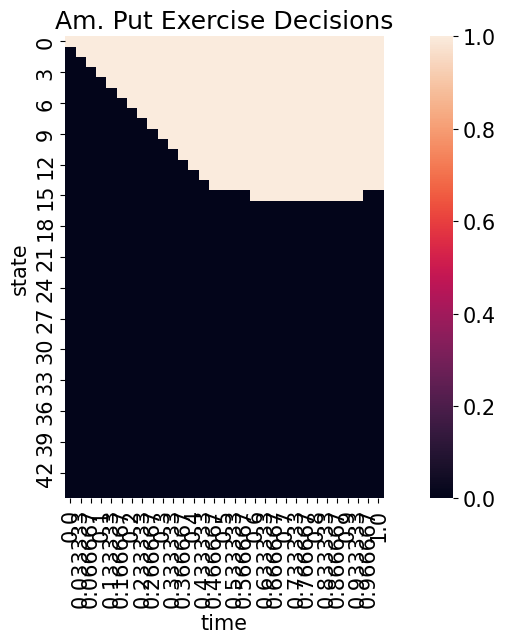

In [59]:
sns.heatmap(exercise_decisions(put_payoff, bondtree_dense.loc[:,:EXPIRATION], put_am_derivtree_dense), square=True).set_title("Am. Put Exercise Decisions")
#axes[1].set_title("Am. Put Exercise Decisions")

plt.show()